In [7]:
import numpy as np
import random
from numpy.linalg import*
import matplotlib.pyplot as plt
from numpy import r_, exp, cos, sin, pi, zeros, ones, hanning, sqrt, log, floor, reshape, mean
from scipy import signal
from numpy.fft import fft
import math
import time
import scipy.optimize as opt

import scipy.io as sio
import scipy.io.wavfile
import sounddevice as sd
from IPython.display import Audio

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import copy
%matplotlib inline
#import Functions_201116
#from Functions_201116 import *

In [8]:
def ArrayVec_deg_WB(N,Angle_deg, freq, vp):
    phi = 2*np.pi*freq*d*math.sin(Angle_deg*np.pi/180)/vp
    a=[]
    for i in range(N):
        a.append(math.e**(i*-1j*phi))
    return np.asarray(a)

def deg2ind(deg_list):              #Convert angle in degree to index of Angle_Sweep   Updated on 15th Nov. 2020
    if type(deg_list) != list:
        deg_list = np.array([deg_list])
    index_list = np.array([])
    for deg in deg_list:
        index_list = np.append(index_list, (N_Angle-1)*(deg-theta_start)/(theta_end - theta_start))
    index_list = index_list.astype(int)
    return index_list

def PeakSearch_Vision(AoA, prom):
    prom_bck=prom

    for j in range(50):
        peaks, _ = signal.find_peaks(10*np.log10(AoA), prominence=prom, height=-15)
        if len(peaks)==0:
            print("Nan")
            prom = 0.9*prom
            continue
        else:
            break
    Angle_S_est = Angle_sweep[peaks]
    if np.max(10*np.log10(AoA)) -0.5  < 10*np.log10(AoA[deg2ind(-90)]):
        Angle_S_est = np.append(Angle_S_est,[-90])
    if np.max(10*np.log10(AoA)) -0.5 < 10*np.log10(AoA[deg2ind(90)]):
        Angle_S_est = np.append(Angle_S_est,[90])
    return Angle_S_est

def Rxx_Gen_WB_t2f(Xs,I,Ns):
    mu = 1e-7
    N = len(Xs[:,0])
    Xs_f = np.zeros((N,1,I,Ns), dtype='complex')     # MIC number x 1 x snapshot x basis number

    for i in range(I):
        Xs_f[:,0,i,:] = np.fft.fft(Xs[:,Ns*i:Ns*i+Ns],axis=1)
    Xs_f = np.fft.fftshift(Xs_f,axes=3)                     # DC is centered 

    # Covariance Matrix
    Rxx_f = np.zeros((N,N,Ns),dtype=complex)
    Rxx_f_inv = np.zeros((N,N,Ns),dtype=complex)
    Rxx_f_raw = np.zeros((N,N,I,Ns),dtype=complex)
    for j in range(len(Xs_f[0,0,0,:])):
        for i in range(I):
            Rxx_f_raw[:,:,i,j] = Xs_f[:,:,i,j] @ np.conjugate(Xs_f[:,:,i,j].T) 
        Rxx_f = np.average(Rxx_f_raw, axis = 2 )
        Rxx_f[:,:,j] = Rxx_f[:,:,j] + mu * np.eye(N)
        Rxx_f_inv[:,:,j] = np.linalg.inv(Rxx_f[:,:,j])
    return Rxx_f, Rxx_f_inv, Xs_f              # All in frequency domain


def AoA_MVDR_WB(Rxx, Rxx_inv, freq):
    vp = 340
    AoA_sweep = np.zeros((N_Angle))      
    for i in range(N_Angle):
        a_theta = ArrayVec_deg_WB(N,Angle_sweep[i],freq, vp) 
        W = (Rxx_inv@a_theta)/(np.conjugate(a_theta.T)@Rxx_inv@a_theta)
        AoA_sweep[i]=np.abs(np.conjugate(W.T)@Rxx@W)
    return AoA_sweep 

def BF_MVDR_WB_f(X_f, Rxx, Rxx_inv, Angle_I, freq):
    vp = 340
    BF = np.zeros((len(Angle_I),1),dtype='complex')      
    for i in range(len(Angle_I)):
        a_theta = ArrayVec_deg_WB(N,Angle_I[i], freq, vp)
        W = (Rxx_inv@a_theta)/(np.conjugate(a_theta.T)@Rxx_inv@a_theta)
        BF[i]=np.conjugate(W.T)@X_f
    return BF

def BF_MVDR_WB_Weights(Rxx, Rxx_inv, Angle_I, freq):
    vp = 340
    W = np.zeros((len(Rxx[:,0]),len(Angle_I)), dtype='complex')      
    for k in range(len(Angle_I)):
        a_theta = ArrayVec_deg_WB(N,Angle_I[k], freq, vp)
        W[:,k] = (Rxx_inv@a_theta)/(np.conjugate(a_theta.T)@Rxx_inv@a_theta)
    return W

def BF_CBF_WB_Weights(Rxx, Rxx_inv, Angle_I, freq):
    vp = 340
    W = np.zeros((len(Rxx[:,0]),len(Angle_I)), dtype='complex')      
    for k in range(len(Angle_I)):
        a_theta = ArrayVec_deg_WB(N,Angle_I[k], freq, vp)
        W[:,k] = a_theta/(np.dot(a_theta,np.conjugate(a_theta)))
    return W

def BF_MVDR_WB(Xs_f_tensor, Rxx_f,Rxx_f_inv, Angle_I, freq):
    
    BF_f = np.zeros((len(Angle_I),Ns*I), dtype='complex')
    BF = np.zeros((len(Angle_I),Ns*I), dtype='complex')
    
    for i in range(I):
        Xs_f = Xs_f_tensor[:,0,i,:]
        #print(Xs_f.shape)

        for j in range(Ns):
  
            BF_f[:,Ns*i+j] = np.conjugate(BF_MVDR_WB_Weights(Rxx_f[:,:,j], Rxx_f_inv[:,:,j], Angle_I, freq[j]).T)@Xs_f[:,j]
            
        BF[:,Ns*i:Ns*i+Ns] = np.fft.ifft(np.fft.fftshift(BF_f[:,Ns*i:Ns*i+Ns],axes=1),axis=1)
    return BF

def BF_CBF_WB(Xs_f_tensor, Rxx_f,Rxx_f_inv, Angle_I, freq):
    
    BF_f = np.zeros((len(Angle_I),Ns*I), dtype='complex')
    BF = np.zeros((len(Angle_I),Ns*I), dtype='complex')
    
    for i in range(I):
        Xs_f = Xs_f_tensor[:,0,i,:]
        #print(Xs_f.shape)
        for j in range(Ns):

            BF_f[:,Ns*i+j] = np.conjugate(BF_CBF_WB_Weights(Rxx_f[:,:,j], Rxx_f_inv[:,:,j], Angle_I, freq[j]).T)@Xs_f[:,j]

        BF[:,Ns*i:Ns*i+Ns] = np.fft.ifft(np.fft.fftshift(BF_f[:,Ns*i:Ns*i+Ns],axes=1),axis=1)
    return BF


def Update_MVDR_Vision(X, Angle_I, Rxx, Rxx_inv):
    # Update X to X_new
    X_new = X
    K_est = len(Angle_I)
    r = list(range(K_est))
    random.shuffle(r)
    print(r)
    for i in r:
        #print(Angle_I[i])
        a_theta_est = ArrayVec_deg(N,Angle_I[i])
        W_est = (Rxx_inv@a_theta_est)/(np.conjugate(a_theta_est.T)@Rxx_inv@a_theta_est)    
        X_sub_est = np.reshape(a_theta_est,(N,1))@np.reshape(np.conjugate(W_est.T)@X_new,(1,len(X[0,:])))
        X_new = X_new - X_sub_est

    return X_new

def AoA_Plot_WB(Angle_sweep,freq, AoA_sweep, level):
    fig = plt.figure(figsize = (8.6,4))
    CS = plt.contourf(Angle_sweep, freq*1e-3, AoA_sweep.T, levels= level,cmap='Reds')
    plt.colorbar(CS,orientation='vertical')
    plt.xlabel('AoA [deg]')
    plt.ylabel('Freq[kHz]')
    plt.tight_layout()
    plt.grid(True,axis='x')
    plt.xticks(np.arange(-90,100,10))
    plt.xlim(-90,90)
    plt.ylim(0,None)
    plt.show()
    
def AoA_Plot(AoA_sweep):
   # fig = plt.figure(figsize = (12,4))
    fig = plt.figure(figsize = (8,2))

    plt.xlim(-90, 90)
    #plt.ylim(-80, 20)
    plt.xticks(np.arange(-90,100,10))
    plt.grid(True)
    plt.plot(Angle_sweep,AoA_sweep)
    for i in Angle:
        if i not in Angle_I:
            plt.vlines(Angle_sweep[deg2ind(i)],ymin=np.min(AoA_sweep[:])/2, ymax=np.max(AoA_sweep[:])*1.2, colors="blue", ls=':', lw=1.5, label='Desired')
        else:
            plt.vlines(Angle_sweep[deg2ind(i)],ymin=np.min(AoA_sweep[:])/2, ymax=np.max(AoA_sweep[:])*1.2, colors="red", ls=':', lw=1.5, label='Interferers')
     
    plt.xlabel('Incident angle [deg]')
    plt.ylabel('Magnitude')
    plt.title('Angle of Arrival Estimation')
    #plt.tight_layout()

def AoA_Plot_dB(AoA_sweep):
    fig = plt.figure(figsize = (8,2))

    plt.xlim(-90, 90)
    #plt.ylim(-80, 20)
    plt.xticks(np.arange(-90,100,10))
    plt.grid(True)
    plt.plot(Angle_sweep,10*np.log10(AoA_sweep))
    for i in Angle:
        if i not in Angle_I:
            plt.vlines(Angle_sweep[deg2ind(i)],ymin=np.min(10*np.log10(AoA_sweep[:]))-10, ymax=np.max(10*np.log10(AoA_sweep[:]))+10, colors="blue", ls=':', lw=1.5, label='Desired')
        else:
            plt.vlines(Angle_sweep[deg2ind(i)],ymin=np.min(10*np.log10(AoA_sweep[:]))-10, ymax=np.max(10*np.log10(AoA_sweep[:]))+10, colors="red", ls=':', lw=1.5, label='Interferers')
     
    plt.xlabel('Incident angle [deg]')
    plt.ylabel('Magnitude [dB]')
    plt.title('Angle of Arrival Estimation')
    #plt.tight_layout()

def AoA_Plot_dB_Together(AoA_sweep, init):
    #fig = plt.figure(figsize = (8,2))
    label_Known = "Known"
    label_Unknown = 'Unknown'
    plt.xlim(-90, 90)
    #plt.ylim(-80, 20)
    plt.xticks(np.arange(-90,100,30))
    plt.grid(True)
    plt.plot(Angle_sweep,10*np.log10(AoA_sweep),label=str(init+1)+'-th iter.')
    if init == 0:
        for i in Angle:
            if i not in Angle_I:
                plt.vlines(Angle_sweep[deg2ind(i)],-5, ymax=np.max(10*np.log10(AoA_sweep[:]))+5, colors="blue", ls=':', lw=1.5, label=label_Unknown)
                label_Unknown = None
            else:
                plt.vlines(Angle_sweep[deg2ind(i)],-5, ymax=np.max(10*np.log10(AoA_sweep[:]))+5, colors="red", ls=':', lw=1.5, label=label_Known)
                label_Known = None
    
    plt.xlabel('Incident angle [deg]')
    plt.ylabel('Ratio Magnitude [dB]')
    #plt.title('Angle of Arrival Estimation')
    plt.legend( bbox_to_anchor=(1.3, 1),loc='upper right')
    
def AoA_Plot_Together(AoA_sweep, init):
    #fig = plt.figure(figsize = (8,2))
    label_Known = "Known"
    label_Unknown = 'Unknown'
    plt.xlim(-90, 90)
    #plt.ylim(-80, 20)
    plt.xticks(np.arange(-90,100,30))
    plt.grid(True)
    plt.plot(Angle_sweep,AoA_sweep,label=str(init+1)+'-th iter.')
    if init == 0:
        for i in Angle:
            if i not in Angle_I:
                plt.vlines(Angle_sweep[deg2ind(i)],ymin=np.min(AoA_sweep[:])/2, ymax=np.max(AoA_sweep[:])*1.2, colors="blue", ls=':', lw=1.5, label=label_Unknown)
                label_Unknown = None
            else:
                plt.vlines(Angle_sweep[deg2ind(i)],ymin=np.min(AoA_sweep[:])/2, ymax=np.max(AoA_sweep[:])*1.2, colors="red", ls=':', lw=1.5, label=label_Known)
                label_Known = None
    
    plt.xlabel('Incident angle [deg]')
    plt.ylabel('Ratio Magnitude')
    #plt.title('Angle of Arrival Estimation')
    plt.legend( bbox_to_anchor=(1.3, 1),loc='upper right')
    

def PeakSearch_Vir(AoA_ratio, Angle_I, prom, Angle_th):
    Angle_S_est = []
    Angle_S_est_max = []
    flag = 0
    peaks, _ = signal.find_peaks(AoA_ratio, prominence=prom)

    for i in Angle_sweep[peaks]:
        if np.min(np.absolute(i-Angle_I)) < Angle_th:
            continue
        #elif np.abs(i)>75:
        #    continue
        else:
            Angle_S_est = np.append(Angle_S_est,i)
    if len(Angle_S_est) == 0:
        flag = 1
    else:
        Angle_S_est_max = Angle_S_est[np.argmax(AoA_ratio[deg2ind(Angle_S_est)])]
    return np.around(Angle_S_est,1), np.around(Angle_S_est_max,1), flag

def PeakSearch_Vir_ratio(AoA_ratio, Angle_I, prom, Angle_th):
    Angle_S_est = []
    Angle_S_est_max = []
    flag = 0
    peaks, _ = signal.find_peaks(AoA_ratio, prominence=prom)

    for i in Angle_sweep[peaks]:
        if np.min(np.absolute(i-Angle_I)) < Angle_th:
            continue
        elif np.abs(AoA_ratio[deg2ind(i)])<1.2:
            continue
        elif np.abs(i)>90:
            continue
        else:
            Angle_S_est = np.append(Angle_S_est,i)
    if len(Angle_S_est) == 0:
        flag = 1
    else:
        Angle_S_est_max = Angle_S_est[np.argmax(AoA_ratio[deg2ind(Angle_S_est)])]
    return np.around(Angle_S_est,1), np.around(Angle_S_est_max,1), flag


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    #y = signal.lfilter(b, a, data)           #With actual delay
    y = signal.filtfilt(b,a, data)            #without delay
    return y
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    #y = signal.lfilter(b, a, data)           #With actual delay
    y = signal.filtfilt(b,a, data)            #without delay
    return y

samplerate: 44100
233319


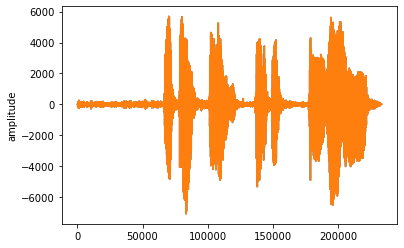

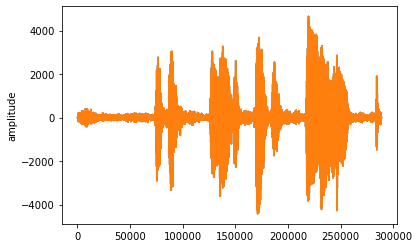

In [9]:
samplerate, HSdata = sio.wavfile.read('./VoiceRecords/AugRecord.wav')
_, JPdata = sio.wavfile.read('./VoiceRecords/JuneRecord.wav')
#data_1 = data[150000-int(samplerate*0.25):150000]

times = np.arange(len(HSdata))/float(samplerate)
sd.play(HSdata, samplerate)
#sd.play(JPdata, samplerate)
print('samplerate:',samplerate)
print(len(HSdata))

plt.figure(0)
plt.plot(HSdata)
plt.ylabel('amplitude')
plt.show()

plt.figure(1)
plt.plot(JPdata)
plt.ylabel('amplitude')
plt.show()

In [6]:
sd.play(JPdata[220000:270000],samplerate)
sd.play(HSdata[50000:100000],samplerate)
sd.play(JPdata[110000:160000],samplerate)
sd.play(HSdata[125000:175000],samplerate)
sd.play(HSdata[170000:220000],samplerate)

In [53]:
print(len(data_i))

1.417233560090703


In [12]:
print(data_i.shape)
print(Ns_true)
print(np.average(data_i,axis=1))
print(np.average(SigVec,axis=1))
print(np.average(X,axis=1))

NameError: name 'data_i' is not defined

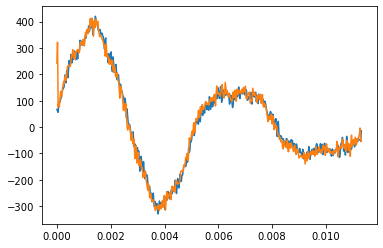

In [10]:
# Signal Generation
Angle = np.array([-60, 12, 70])#, -45, -5])#, 30, 45, 65])     # Impinging Angles
K = len(Angle)      #  Number of impinging signals

samplerate, HSdata = sio.wavfile.read('./VoiceRecords/AugRecord.wav')
_, JPdata = sio.wavfile.read('./VoiceRecords/JuneRecord.wav')
HSdata = HSdata[:,0]
JPdata = JPdata[:,0]


data_i = np.zeros((K,50000))
data_i[0,:] = JPdata[210000:260000]   # 0.25 second signal
data_i[1,:] = HSdata[50000:100000]
data_i[2,:] = HSdata[45000:95000]
#data_i[2,:] = JPdata[110000:160000]
#data_i[3,:] = HSdata[125000:175000]
#data_i[4,:] = HSdata[170000:220000] 


# Add zero pad if sample length is odd
if len(data_i[0,:])%2!=0:
    data_i = np.pad(data_i,pad_width = ((0, 0), (0, 1)), constant_values=0)

# interpolation is done to mimic true physical signals arriving. 
Upsample_factor = 1
data_true_i = np.zeros((K, Upsample_factor*len(data_i[0,:])))

for i in range(K):
    data_true_i[i,:] = data_i[i,:]                                                          #Without Upsampling
    #data_true_i[i,:] = signal.resample(data_i[i,:], len(data_i[i,:])*Upsample_factor)      #With Upsampling


Ns_true = len(data_true_i[0,:])    # Sample number 
fs_true = samplerate*Upsample_factor   # Modeling frequency of real signals
# This makes fs_true/Ns_true = 10 Hz resolution in freq domain

t_true = np.arange(Ns_true)/fs_true



SigVec = np.zeros((K,Ns_true))
SigVec_f = np.zeros((K,Ns_true), dtype='complex')

for i in range(K):
    SigVec[i,:] = (data_true_i[i,:])# - np.average(data_i[i,:]))


for i in range(K):
    SigVec_f[i,:] = np.fft.fft(SigVec[i,:])
SigVec_f = np.fft.fftshift(SigVec_f, axes=1)      # DC is centered by fftshift 


# Linear Arrays referenced at the edge of element.
N= 6 # Antenna array count
vp = 340    # Propagation velocity in [m/s]
d_over_lamb = 0.5   # distance between element / wavelength
d = d_over_lamb*vp/(10e+3) # fmax is assumed to be 10 KHz


############# Array Matrix   #############
A = np.zeros((N,K), dtype='complex')
X_f = np.zeros((N,Ns_true), dtype='complex')

if Ns_true%2==0:
    freq_true = np.linspace(-fs_true/2, fs_true/2-fs_true/Ns_true, Ns_true)
else:
    freq_true = np.linspace(-fs_true/2 + 0.5*fs_true/Ns_true, fs_true/2-0.5*fs_true/Ns_true, Ns_true)


for j in range(Ns_true):
    for i in range(K): 
        A[:,i] = ArrayVec_deg_WB(N,Angle[i],freq_true[j],vp)
    X_f[:,j] = A@SigVec_f[:,j]       # Signal after MIC arrays

X_f = np.fft.fftshift(X_f, axes=1)      # DC is back to first by fftshift 
    
# Measurement vector in time domain
X = np.fft.ifft(X_f,axis=1)
X = np.real(X)     # Drop the imaginary part

Disp = 500
plt.plot(t_true[:Disp],X[0,:Disp])
plt.plot(t_true[:Disp],X[1,:Disp])
#plt.plot(t_true[:Disp],X[2,:Disp])
#plt.plot(t_true[:Disp],X[3,:Disp])

# Noise vector
SNR = 30  #[dB]
#np.random.seed(0)
SigMaxVar = np.max(np.var(SigVec,axis=1))/2
noiseVec =  np.random.normal(0,np.sqrt(SigMaxVar/(10**(SNR/10))),size=(N,len(SigVec[0,:])))    #Noise in time domain is real


X = X + noiseVec



In [11]:
Audio(SigVec[0,:], rate=fs_true)
Audio(SigVec[1,:], rate=fs_true)
Audio(SigVec[2,:], rate=fs_true)

In [15]:
Audio(X[0,:], rate=fs_true)

In [908]:
print(fs_true)
print(samplerate)
print(len(data))
print(len(data_true_i[:,0]))

print(np.max(t_true))
print(Ns_true)
print(fs_true/Ns_true)
print(SigVec.shape)

44100
44100
233319
3
1.133764172335601
50000
0.882
(3, 50000)


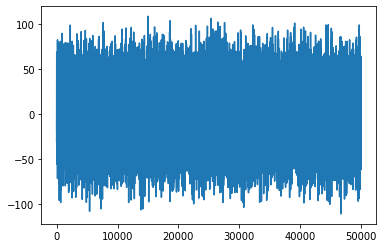

In [943]:
plt.figure(0)
#plt.plot(X[0,:])
SigVec_sum = np.sum(SigVec,axis=0)#+SigVec[1,:]+SigVec[2,:]+SigVec[3,:]+SigVec[4,:]
#plt.plot(SigVec_sum)
plt.plot(X[0,:]-SigVec_sum)

In [12]:

############## Lowpass filter #############
X_LP = np.zeros((N,Ns_true))
f_cutoff = fs_true/4    # 8820 Hz
for i in range(N):
    X_LP[i,:] =  butter_lowpass_filter(X[i,:], f_cutoff, fs_true, 10)

############## Sampling #############
f_ADC = fs_true/2   # 8820 * 2 Hz
factor_ADC = int(fs_true/f_ADC)
X_ADC = X_LP[:,::factor_ADC]        # in time domain

for i in range(len(X_ADC[:,0])):
    X_ADC[i,:] = X_ADC[i,:]-np.average(X_ADC[i,:])

I = 50    # Number of snapshot(packet) to catch
Ns = 500   # Number of samples to take within a snapshot(packet)
t_ADC = np.arange(Ns*I)/f_ADC
############ Covariance Matrix generation    ###############
Rxx_f, Rxx_f_inv, Xs_f_tensor = Rxx_Gen_WB_t2f(X_ADC,I,Ns)          # input: time series, output: covariance matrix function of freq.

print("f_ADC:" ,f_ADC)
print(X_ADC.shape)
print(Rxx_f.shape)
print(Xs_f_tensor.shape)
# ##  Rxx_raw_try[:,:] = Xs_f[:,:] @ np.conjugate(Xs_f[:,:].T)    --- Check later for parallel method 

f_ADC: 22050.0
(6, 25000)
(6, 6, 500)
(6, 1, 50, 500)


In [13]:
##### MVDR block for look direction ########
#Angle_Unk = [0,3,4]
Angle_Tar= Angle
if Ns%2==0:
    freq_s = np.linspace(-f_ADC/2, f_ADC/2-f_ADC/Ns, Ns)
else:
    freq_s = np.linspace(-f_ADC/2 + 0.5*f_ADC/Ns, f_ADC/2-0.5*f_ADC/Ns, Ns)

print("Target Angles [deg]:",Angle_Tar)
SigVec_Tar = np.real(BF_MVDR_WB(Xs_f_tensor, Rxx_f,Rxx_f_inv, Angle_Tar, freq_s))          # MVDR weight and read
#SigVec_Tar = np.real(BF_CBF_WB(Xs_f_tensor, Rxx_f,Rxx_f_inv, Angle_Tar, freq_s))             # CBF weight and read

Target Angles [deg]: [-60  12  70]


In [14]:
Audio(np.real(SigVec_Tar[0,:]), rate=f_ADC)

In [15]:
Audio(np.real(SigVec_Tar[1,:]), rate=f_ADC)

In [16]:
Audio(np.real(SigVec_Tar[2,:]), rate=f_ADC)

In [22]:
Audio(np.real(SigVec_Tar[3,:]), rate=f_ADC)

IndexError: index 3 is out of bounds for axis 0 with size 3

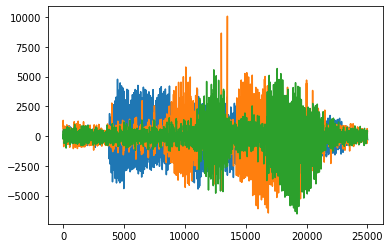

In [949]:
plt.plot(SigVec_Tar[0,:])
plt.plot(SigVec_Tar[1,:])
plt.plot(SigVec_Tar[2,:])

Pearson r of 0-th sig = 0.8942937752253183
Pearson r of 1-th sig = 0.8165715257284506
Pearson r of 2-th sig = 0.8623362134972614


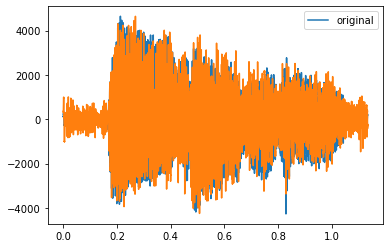

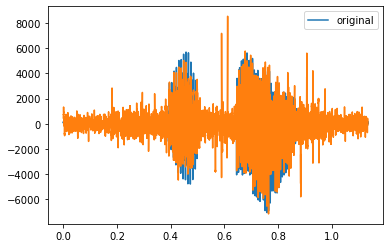

In [17]:
###### Evaluation of speech enhancement ######
plt.figure(0)
plt.plot(t_ADC,SigVec[0,::factor_ADC], label ='original')
plt.plot(t_ADC,SigVec_Tar[0,:])
plt.legend()
plt.figure(1)
plt.plot(t_ADC,SigVec[1,::factor_ADC], label='original')
plt.plot(t_ADC,SigVec_Tar[1,:])
plt.legend()
# Printing Pearson r
for i in range(K):
    print('Pearson r of %d-th sig =' %i, np.corrcoef(SigVec[i,::factor_ADC], SigVec_Tar[i,:])[1,0])



In [855]:
# Raw spectrum of AoA
#N_Angle=181
#Angle_sweep = np.linspace(-90,90,N_Angle)  #Angle resolution in plot is 0.1 deg
dtheta = 1          #Angle resolution
theta_start = -180
theta_end = 180
N_Angle = 1+int((theta_end - theta_start)/dtheta)

Angle_sweep = np.linspace(theta_start,theta_end,N_Angle)  #Angle resolution in plot is 0.1 deg

AoA_sweep = np.zeros((N_Angle,Ns))       # These are amplitudes in real number (not complex value)


for j in range(Ns):
    AoA_sweep[:,j] = AoA_MVDR_WB(Rxx_f[:,:,j], Rxx_f_inv[:,:,j], freq_s[j])
#AoA_sweep[AoA_sweep<np.max(AoA_sweep)*1e-3]=1e-10    
AoA_sweep_norm = AoA_sweep/np.max(AoA_sweep)

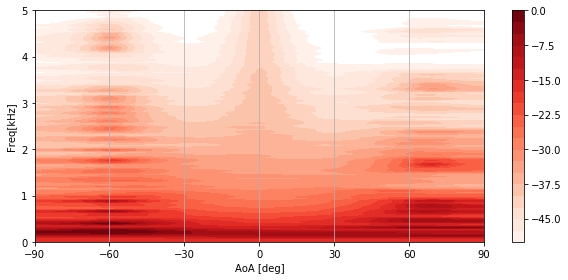

In [856]:
# AoA plot purpose
AoA_sweep_norm = AoA_sweep/np.max(AoA_sweep)
# Generating 1D AoA plot
fig = plt.figure(figsize = (8.6,4))
CS = plt.contourf(Angle_sweep, freq_s[:len(AoA_sweep_norm[0,:])]*1e-3, 10*np.log10(AoA_sweep_norm).T, levels= np.linspace(-50,0,21),cmap='Reds')
plt.colorbar(CS,orientation='vertical')
plt.xlabel('AoA [deg]')
plt.ylabel('Freq[kHz]')
plt.tight_layout()
plt.grid(True,axis='x')
plt.xticks(np.arange(-90,100,30))
plt.xlim(-90,90)
plt.ylim(0,5)
plt.show()


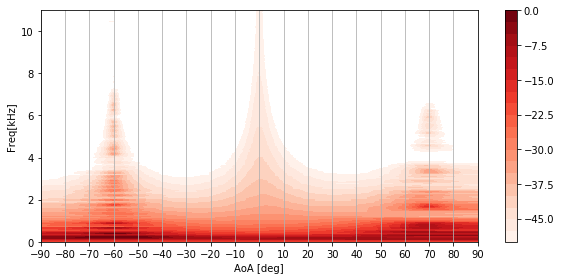

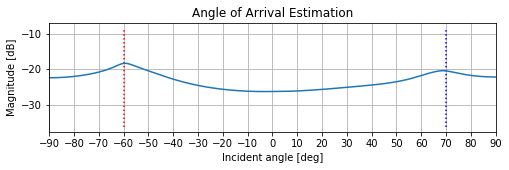

In [744]:
# Raw signal AoA plot
AoA_sweep_norm = AoA_sweep/np.max(AoA_sweep)
#AoA_Plot_WB(Angle_sweep,freq_s[250:325], 20*np.log10(AoA_sweep_norm[:,250:325]), np.linspace(-100,0,21))
AoA_Plot_WB(Angle_sweep,freq_s, 10*np.log10(AoA_sweep_norm), np.linspace(-50,0,21))

AoA_Plot_dB(np.average(AoA_sweep_norm,axis=1))

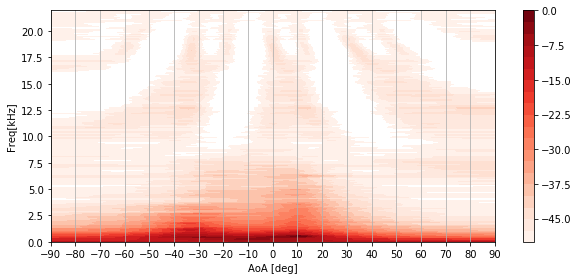

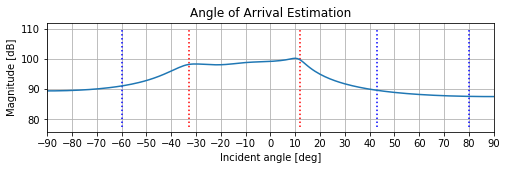

In [454]:
# Virtual signal AoA plot
AoA_Plot_WB(Angle_sweep,freq_s, 10*np.log10(AoA_sweep_norm_vir), np.linspace(-50,0,21))

# Generating 1D AoA plot
AoA_Plot_dB(np.average(AoA_sweep_vir,axis=1))

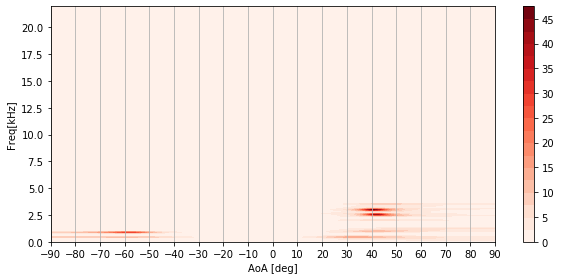

peak_ratio: [-122.  -58.   41.  139.]


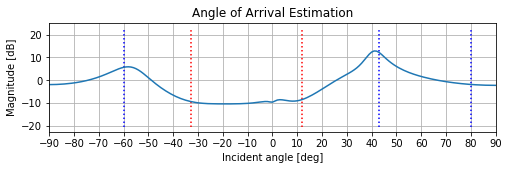

In [469]:
# Ratio-based plot
AoA_Plot_WB(Angle_sweep,freq_s, AoA_ratio, 21)

# Generating 1D AoA plot
AoA_ratio_1D = np.var(AoA_ratio,axis=1)
AoA_Plot_dB(AoA_ratio_1D)
peaks_ratio, _ = signal.find_peaks(AoA_ratio_1D, prominence=np.max(AoA_ratio_1D)*0.1)
print("peak_ratio:",Angle_sweep[peaks_ratio])
#AoA_ratio_1D = np.var(AoA_sweep,axis=1)/np.var(AoA_sweep_vir,axis=1)           #Divide first then take variance
#AoA_Plot(AoA_ratio_1D)

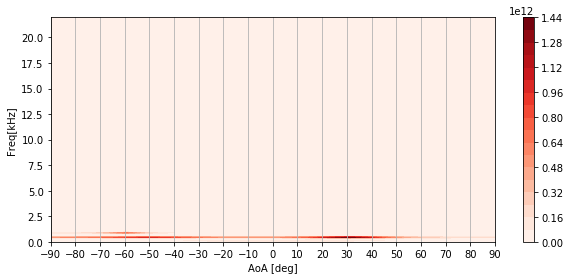

peak_diff: [-130.  -50.   31.  149.]


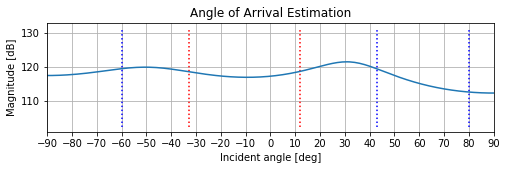

In [456]:
# Diff-based plot
AoA_Plot_WB(Angle_sweep,freq_s, AoA_diff, 21)
# Generating 1D AoA plot
AoA_diff_1D = np.max(AoA_diff,axis=1)
AoA_Plot_dB(AoA_diff_1D)
peaks_diff, _ = signal.find_peaks(AoA_diff_1D, prominence=np.max(AoA_diff_1D)*0.1)
print("peak_diff:",Angle_sweep[peaks_diff])

[41.]
41.0
[-60.]
-60.0
Final Estimate is: [ 41. -60.]


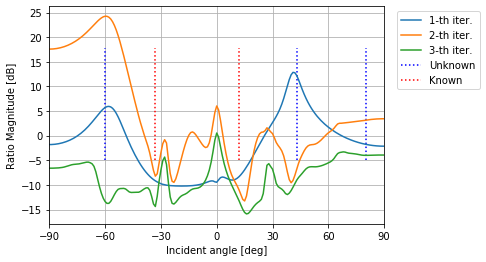

In [470]:
# Ratio version algorithm -- plot purpose

#prom = np.max(AoA_ratio_bck)*0.25
Angle_th = 10
Angle_I_vir = copy.deepcopy(Angle_I)
Angle_S = []
Angle_S_est = []
X_vir = copy.deepcopy(X_ADC)
Rxx_vir_f = copy.deepcopy(Rxx_f)
flag_break = 0
AoA_sweep_vir = copy.deepcopy(AoA_sweep_vir_bck)
init = 0 
G_s = 1
for i in range(30):
    AoA_ratio_1D = np.average(AoA_sweep/AoA_sweep_vir,axis=1)
    #AoA_ratio_1D = G_s * signal.savgol_filter(AoA_ratio_1D,21,3)         # Smooth and Scale
    #AoA_ratio_1D = np.var(AoA_sweep,axis=1)/np.var(AoA_sweep_vir,axis=1)
    #AoA_ratio_1D = signal.savgol_filter(AoA_ratio_1D,21,3)      #filtering for smoothing purpose
        
    prom = np.max(AoA_ratio_1D)*0.25/(flag_break*0.5+1) #*0.2 /(i+1) 
    
    Angle_S_est, Angle_S_est_max, flag = PeakSearch_Vir_ratio(AoA_ratio_1D, Angle_I_vir, prom, Angle_th)
    if flag == 1:
        prom = prom*0.8
        flag_break = flag_break+1
        if flag_break == 10:
            AoA_Plot_dB_Together(AoA_ratio_1D, init)
            break
        continue
    flag_break = 0
    
    AoA_Plot_dB_Together(AoA_ratio_1D, init)
    init = init+1
    
    print(Angle_S_est)
    print(Angle_S_est_max)

    Angle_S = np.append(Angle_S,Angle_S_est_max)
    Angle_I_vir = np.append(Angle_I_vir,Angle_S_est_max)
    
    SigVec_vir = BF_MVDR_WB(Xs_f_tensor, Rxx_f,Rxx_f_inv, Angle_I_vir, freq_s)          # MVDR weight and read
    #SigVec_vir = BF_CBF_WB(Xs_f_tensor, Rxx_f,Rxx_f_inv, Angle_I_vir, freq_s)          # CBF weight and read

    ############# Virtual Array Matrix   #############
    A_vir = np.zeros((N,len(Angle_I_vir)), dtype='complex')
    X_vir_f = np.zeros((N,Ns*I), dtype='complex')
    freq_vir = np.arange(-f_ADC/2, f_ADC/2, f_ADC/(Ns*I))
    for j in range(Ns*I):
        for i in range(len(Angle_I_vir)): 
            A_vir[:,i] = ArrayVec_deg_WB(N,Angle_I_vir[i],freq_vir[j],vp)
        X_vir_f[:,j] = (A_vir@np.fft.fftshift(np.fft.fft(SigVec_vir,axis=1),axes=1))[:,j]       # Signal after MIC arrays

    X_vir_f = np.fft.fftshift(X_vir_f, axes=1)      # DC is back to first by fftshift 

    # Measurement vector in time domain
    X_vir = np.fft.ifft(X_vir_f,axis=1)

    for i in range(len(X_vir[:,0])):
        X_vir[i,:] = X_vir[i,:]-np.average(X_vir[i,:])    
    
    Rxx_vir_f, Rxx_vir_f_inv, _ = Rxx_Gen_WB_t2f(X_vir,I,Ns)

    for j in range(Ns):
        AoA_sweep_vir[:,j] = AoA_MVDR_WB(Rxx_vir_f[:,:,j], Rxx_vir_f_inv[:,:,j], freq_s[j])
    #AoA_sweep_vir[AoA_sweep_vir<np.max(AoA_sweep_vir)*1e-3]=1e-10       #Make lower bound 
    
print('Final Estimate is:',Angle_S)

#Note: When maximum level is similar, depending on which one to choose as maximum, end-result is different. 
#  We could take all cases then take average.

In [ ]:
print(AoA_sweep_norm.shape)
print(Angle_sweep.shape)
print(freq_s.shape)

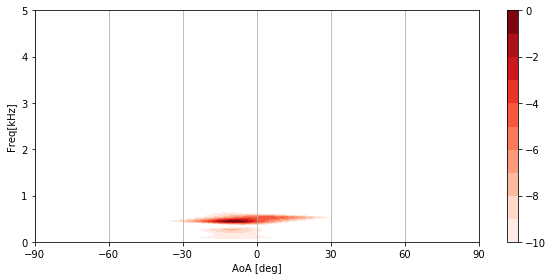

In [472]:
# AoA plot purpose

# Generating 1D AoA plot
fig = plt.figure(figsize = (8.6,4))
CS = plt.contourf(Angle_sweep, freq_s[:len(AoA_sweep_norm[0,:])]*1e-3, 10*np.log10(AoA_sweep_norm_vir).T, levels= np.linspace(-SNR,0,11),cmap='Reds')
plt.colorbar(CS,orientation='vertical')
plt.xlabel('AoA [deg]')
plt.ylabel('Freq[kHz]')
plt.tight_layout()
plt.grid(True,axis='x')
plt.xticks(np.arange(-90,100,30))
plt.xlim(-90,90)
plt.ylim(0,5)
plt.show()


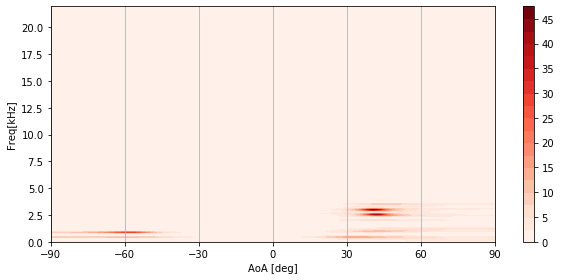

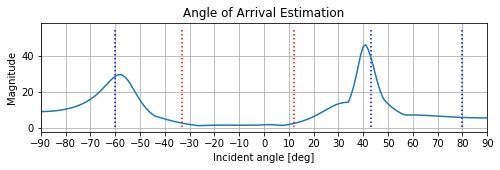

In [473]:
# AoA plot purpose

# Generating 1D AoA plot
fig = plt.figure(figsize = (8.6,4))
CS = plt.contourf(Angle_sweep, freq_s[:len(AoA_sweep_norm[0,:])]*1e-3, AoA_ratio.T, levels= 21,cmap='Reds')
plt.colorbar(CS,orientation='vertical')
plt.xlabel('AoA [deg]')
plt.ylabel('Freq[kHz]')
plt.tight_layout()
plt.grid(True,axis='x')
plt.xticks(np.arange(-90,100,30))
plt.xlim(-90,90)
plt.ylim(0,None)
plt.show()
AoA_Plot(np.max(AoA_ratio,axis=1))

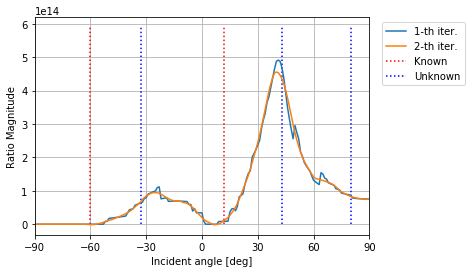

In [410]:
AoA_Plot_Together(np.average(AoA_ratio,axis=1), 0)
AoA_Plot_Together(signal.savgol_filter(np.average(AoA_ratio,axis=1),21,3), 1)

In [ ]:
# AoA plot purpose

AoA_Plot(signal.savgol_filter(np.average(AoA_ratio,axis=1),21,3))

In [ ]:
# Using  MVDR, perform iterative reconstruction    --- Ratio version
#prom = np.max(AoA_ratio_bck)*0.25
Angle_th = 10
Angle_I_vir = copy.deepcopy(Angle_I)
Angle_S = []
Angle_S_est = []
X_vir = copy.deepcopy(X_ADC)
Rxx_vir_f = copy.deepcopy(Rxx_f)
flag_break = 0
AoA_sweep_vir = copy.deepcopy(AoA_sweep_vir_bck)

for i in range(50):
    AoA_ratio_1D = np.average(AoA_sweep/AoA_sweep_vir,axis=1)
    AoA_ratio_1D = signal.savgol_filter(AoA_ratio_1D,21,3)
    #AoA_ratio_1D = np.var(AoA_sweep,axis=1)/np.var(AoA_sweep_vir,axis=1)
    #AoA_ratio_1D = signal.savgol_filter(AoA_ratio_1D,21,3)      #filtering for smoothing purpose
        
    prom = np.max(AoA_ratio_1D)*0.5/(flag_break*0.5+1) #*0.2 /(i+1) 
    
    Angle_S_est, Angle_S_est_max, flag = PeakSearch_Vir_ratio(AoA_ratio_1D, Angle_I_vir, prom, Angle_th)
    if flag == 1:

        flag_break = flag_break+1
        if flag_break == 10:
            AoA_Plot(AoA_ratio_1D)
            break
        continue
    flag_break = 0
    
    #AoA_Plot(AoA_ratio_1D)
    ################################# AoA Plot module spread out
    #fig = plt.figure(figsize = (8,2))

    plt.xlim(-90, 90)
    #plt.ylim(-80, 20)
    plt.xticks(np.arange(-90,100,10))
    plt.grid(True)
    
    plt.plot(Angle_sweep,10*np.log10(AoA_ratio_1D)) #))AoA_ratio_1D)
    #for i in Angle:
    #    if i not in Angle_I:
    #        plt.vlines(Angle_sweep[deg2ind(i)],ymin=np.min(AoA_ratio_1D[:])/2, ymax=np.max(AoA_ratio_1D[:])*1.2, colors="blue", ls=':', lw=1.5, label='Desired')
    #    else:
    #        plt.vlines(Angle_sweep[deg2ind(i)],ymin=np.min(AoA_ratio_1D[:])/2, ymax=np.max(AoA_ratio_1D[:])*1.2, colors="red", ls=':', lw=1.5, label='Interferers')
     
    plt.xlabel('Incident angle [deg]')
    plt.ylabel('Magnitude')
    plt.title('Angle of Arrival Estimation')
    ##################################
    
    
    
    
    
    print(Angle_S_est)
    print(Angle_S_est_max)

    Angle_S = np.append(Angle_S,Angle_S_est_max)
    Angle_I_vir = np.append(Angle_I_vir,Angle_S_est_max)
    
    SigVec_vir = BF_MVDR_WB(Xs_f_tensor, Rxx_f,Rxx_f_inv, Angle_I_vir, freq_s)          # MVDR weight and read
    #SigVec_vir = BF_CBF_WB(Xs_f_tensor, Rxx_f,Rxx_f_inv, Angle_I_vir, freq_s)          # CBF weight and read

    ############# Virtual Array Matrix   #############
    A_vir = np.zeros((N,len(Angle_I_vir)), dtype='complex')
    X_vir_f = np.zeros((N,Ns*I), dtype='complex')
    freq_vir = np.arange(-f_ADC/2, f_ADC/2, f_ADC/(Ns*I))
    for j in range(Ns*I):
        for i in range(len(Angle_I_vir)): 
            A_vir[:,i] = ArrayVec_deg_WB(N,Angle_I_vir[i],freq_vir[j],vp)
        X_vir_f[:,j] = (A_vir@np.fft.fftshift(np.fft.fft(SigVec_vir,axis=1),axes=1))[:,j]       # Signal after MIC arrays

    X_vir_f = np.fft.fftshift(X_vir_f, axes=1)      # DC is back to first by fftshift 

    # Measurement vector in time domain
    X_vir = np.fft.ifft(X_vir_f,axis=1)

    Rxx_vir_f, Rxx_vir_f_inv, _ = Rxx_Gen_WB_t2f(X_vir,I,Ns)

    for j in range(Ns):
        AoA_sweep_vir[:,j] = AoA_MVDR_WB(Rxx_vir_f[:,:,j], Rxx_vir_f_inv[:,:,j], freq_s[j])
      
    
print('Final Estimate is:',Angle_S)

#Note: When maximum level is similar, depending on which one to choose as maximum, end-result is different. 
#  We could take all cases then take average.

In [ ]:
fig = plt.figure(figsize = (10,5))
ax = fig.gca(projection='3d')
xx, yy = np.meshgrid(Angle_sweep, freq_s*0.001)
surf = ax.plot_surface(xx, yy, 20*np.log10(AoA_sweep_norm.T),cmap='Reds')

ax.set_xlabel('AoA [deg]')
ax.set_ylabel('Freq[kHz]')
ax.set_zlabel('Magnitude [dB]')
plt.tight_layout()

plt.show()



In [ ]:
fig = plt.figure(figsize = (8,2))
plt.xlim(-90, 90)
plt.xticks(np.arange(-90,100,10))
plt.grid(True)
plt.plot(Angle_sweep,np.average(AoA_sweep,axis=1))

plt.xlabel('Incident angle [deg]')
plt.ylabel('Magnitude')
plt.title('Angle of Arrival Estimation')

In [ ]:
print(SigVec_vir.shape)

plt.figure(0)
plt.plot(t_ADC[:300],SigVec_vir[1,:300])
plt.plot(t_true[:3000],SigVec[1,:3000])
plt.figure(1)
plt.plot(1e-3*np.fft.fftshift(freq_s),np.abs(np.fft.fft(SigVec_vir[1,:Ns])))

In [ ]:
plt.plot(t_true[:Disp],X[0,:Disp])
plt.plot(t_true[:Disp],X[1,:Disp])
plt.plot(t_true[:Disp],X[2,:Disp])
plt.plot(t_true[:Disp],X[3,:Disp])

In [ ]:
Nt = Nbits * Ns  #Total number of samples

############# Array Matrix   #############
A = np.zeros((N,K), dtype='complex')
for i in range(K):
    A[:,i] = ArrayVec_deg(N,Angle[i])

t = r_[0.0:Nt]/(fs)


Ps_ref = 0           #Power of signal in dBm for reference-- Slevel = 1
cutoff_index = 40000
SigVec = np.zeros((Nt-cutoff_index,K), dtype='complex')
for i in range(K):
    SigVec[:,i] = np.sqrt(2)*100*10**(Ps_ref/20)*Slevel[i]*QAM_s[cutoff_index:Nt,i]
    
Nt = Nt-cutoff_index
print(SigVec.shape, A.shape)

############## Sampling #############
f_ADC = fs/(320)
factor_ADC = int(fs/f_ADC)
SigVec = SigVec[::factor_ADC,:].T
print(SigVec.shape)


# Noise vector
SNR = 30  #[dB]
#np.random.seed(0)
SigMaxVar = np.max(np.var(SigVec,axis=1))/2
noiseVec = np.random.normal(0,np.sqrt(SigMaxVar/(10**(SNR/10))),size=(N,len(SigVec[0,:])))+1j*np.random.normal(0,np.sqrt(SigMaxVar/(10**(SNR/10))),size=(N,len(SigVec[0,:])))
#noiseVec = 10**((20*np.log10(np.max(Slevel))-SNR)/20)*np.random.randn(N,len(SigVec[0,:]))
print(noiseVec.shape)

plt.plot((SigVec.T))

# Signal after antenna
X = A@SigVec + noiseVec   #  N x Nt
print(X.shape)



In [ ]:
############ LCMV or MVDR block for AoA and Update of X############
#Angle_I = np.delete(Angle,[3,5,0,10])#,3,5,9,10])      #Desired signal angle estimate.

Angle_Unk = [0,2,4,5,8]
#Angle_Unk = [0,2,3,4,6,7,8]                                     # Index of unknown signals 
#Angle_Unk = [1,2,3,4]
Angle_I = np.delete(Angle,Angle_Unk)#,3,5,9,10])      # Desired signal angle estimate.

C = np.zeros((N,len(Angle_I)), dtype='complex')
for i in range(len(Angle_I)):
    C[:,i] = ArrayVec_deg(N,Angle_I[i])
    
print(Angle)
N_Angle=1801
Angle_sweep = np.linspace(-90,90,N_Angle)  #Angle resolution in plot is 0.1 deg
Rxx, Rxx_inv = Rxx_Gen(X)
AoA_sweep = AoA_MVDR(X,Rxx,Rxx_inv)
#AoA_sweep = AoA_CBF(X,Rxx)
AoA_Plot(AoA_sweep)
peaks_MVDR, _ = signal.find_peaks(AoA_sweep, prominence=10)
print(Angle_sweep[peaks_MVDR])
                                    ############ Virtual Signal Generation#################
A_vir = C
#SigVec_vir = np.linalg.pinv(A_vir)@X                      #LS method
#SigVec_vir = BF_CBF(X, Angle_I)

SigVec_vir = BF_MVDR(X, Rxx, Rxx_inv,Angle_I)
#noiseVec_vir = 10**((20*np.log10(np.max(np.average(SigVec_vir,axis=1)))-SNR)/20)*np.random.randn(len(SigVec[:,0]),len(SigVec[0,:]))
SigVec_vir = SigVec_vir #+ noiseVec_vir
#SigVec_vir = BF_LCMV(X, Rxx, Rxx_inv,Angle_I,C)
#SigVec_vir = np.delete(SigVec,Angle_Unk,axis=0)     # Truth value provided 



#### Signal after antenna (Virtual)
#np.random.seed(0)
#noiseVec_vir = 10**((20*np.log10(np.max(Slevel))-SNR)/20)*np.random.randn(N,len(SigVec[0,:]))
#noiseVec_vir = 1e-5*np.random.randn(N,len(SigVec[0,:]))
SNR_vir = 100
SigMaxVar_vir = np.max(np.var(SigVec_vir,axis=1))/2
noiseVec_vir = np.random.normal(0,np.sqrt(SigMaxVar_vir/(10**(SNR_vir/10)))
                                ,size=(N,len(SigVec_vir[0,:])))+1j*np.random.normal(0,np.sqrt(SigMaxVar_vir/(10**(SNR_vir/10))),size=(N,len(SigVec_vir[0,:])))

X_vir = A_vir@SigVec_vir + noiseVec_vir #  N x Nt
#X_vir_MV = A_vir@SigVec_vir_MV #  N x Nt

# Reconstruct first to compare with original
Rxx_vir, Rxx_vir_inv = Rxx_Gen(X_vir)
AoA_sweep_vir = AoA_MVDR(X_vir,Rxx_vir,Rxx_vir_inv)                        # MVDR
#AoA_sweep_vir = AoA_CBF(X_vir,Rxx_vir)                                      #CBF 
AoA_Plot(AoA_sweep_vir)
AoA_sweep_vir_bck = AoA_sweep_vir


# Taking difference 
Rxx_vir_diff, Rxx_vir_inv_diff = Rxx_Gen(X-X_vir)
AoA_sweep_vir_diff = AoA_MVDR(X-X_vir,Rxx_vir_diff,Rxx_vir_inv_diff)                   # MVDR
#AoA_sweep_vir_diff = AoA_CBF(X-X_vir,Rxx_vir_diff)                                      #CBF 
#AoA_sweep_vir_diff_bck = AoA_sweep_vir_diff

#print(noiseVec_vir)

In [ ]:
# Multiple snapshot plot
Snap = 6
AoA_sweep_Snap = np.zeros((N_Angle,Snap))
AoA_sweep_vir_Snap = np.zeros((N_Angle,Snap))

In [ ]:
AoA_sweep_Snap[:,5]=AoA_sweep
AoA_sweep_vir_Snap[:,5]=AoA_sweep_vir

In [ ]:
Snap_label = ['10M','50M','100M','250M','500M','1G']
AoA_Plot_Snap(AoA_sweep_Snap,Snap, Snap_label)
AoA_Plot_Snap(AoA_sweep_vir_Snap,Snap, Snap_label)

In [ ]:
print(SigVec_vir.shape)
print(np.average(np.square(np.linalg.norm(SigVec_vir,ord=2,axis=1))))

In [ ]:
#AoA_diff = AoA_sweep-AoA_sweep_vir    # Taking difference after multiplying weights: Didn't work well.
AoA_diff = AoA_sweep_vir_diff     #Define difference-one as this.(subtract by snapshot then multiply weights)
AoA_diff_bck = AoA_diff
AoA_ratio = AoA_sweep/AoA_sweep_vir
AoA_ratio_bck = AoA_ratio

AoA_Plot(AoA_ratio)   # Divide after multiplying weights
AoA_Plot(AoA_diff)   # Take difference then multiply weights

peaks_ratio, _ = signal.find_peaks(AoA_ratio, prominence=np.max(AoA_ratio)*0.03)
peaks_diff, _ = signal.find_peaks(AoA_diff, prominence=np.max(AoA_diff)*0.03)
print("peak_ratio:",Angle_sweep[peaks_ratio])
print("peak_diff:",Angle_sweep[peaks_diff])

In [ ]:
# Using  MVDR, perform iterative reconstruction    --- Ratio version
#prom = np.max(AoA_ratio_bck)*0.25
Angle_th = 5
Angle_I_vir = Angle_I
Angle_S = []
Angle_S_est = []
X_vir = X
Rxx_vir = Rxx
flag_break = 0
AoA_sweep_vir = AoA_sweep_vir_bck
#AoA_Plot(AoA_sweep/AoA_sweep_vir)
for i in range(50):
    AoA_ratio = AoA_sweep/AoA_sweep_vir
    AoA_ratio = signal.savgol_filter(AoA_ratio,201,3)

        
    prom = np.max(AoA_ratio)*0.25/(flag_break*0.5+1) #*0.2 /(i+1) 
    
    Angle_S_est, Angle_S_est_max, flag = PeakSearch_Vir_ratio(AoA_ratio, Angle_I_vir, prom, Angle_th)
    if flag == 1:
        prom = prom*0.8
        flag_break = flag_break+1
        if flag_break == 10:
            AoA_Plot(AoA_ratio)
            break
        continue
    flag_break = 0
    
    AoA_Plot(AoA_ratio)
    #AoA_Plot(AoA_ratio_hat)
    print(Angle_S_est)
    print(Angle_S_est_max)
    #print(AoA_ratio[deg2ind(Angle_S_est)])
    Angle_S = np.append(Angle_S,Angle_S_est_max)
    Angle_I_vir = np.append(Angle_I_vir,Angle_S_est_max)
    
    A_vir = np.zeros((N,len(Angle_I_vir)), dtype='complex')
    for i in range(len(Angle_I_vir)):
        A_vir[:,i] = ArrayVec_deg(N,Angle_I_vir[i])
    
    SigVec_vir = BF_MVDR(X, Rxx, Rxx_inv, Angle_I_vir)      # Should I update X, Rxx ? Nah..  # MVDR update
    #SigVec_vir = np.linalg.pinv(A_vir)@X
    #SigVec_vir = BF_CBF(X, Angle_I_vir)                                # CBF update
    #SigVec_vir = BF_LCMV(X, Rxx, Rxx_inv,Angle_I_vir,A_vir)
    
    #SigVec_vir = BF_MVDR(X_vir, Rxx_vir, Rxx_vir_inv, Angle_I_vir)      
    

    X_vir = A_vir@SigVec_vir  #  N x Nt
    Rxx_vir, Rxx_vir_inv = Rxx_Gen(X_vir)
    AoA_sweep_vir = AoA_MVDR(X_vir,Rxx_vir,Rxx_vir_inv)                 # MVDR update
    #AoA_sweep_vir = AoA_CBF(X_vir,Rxx_vir)                               # CBF update
    #AoA_Plot(AoA_sweep_vir)

    
    
print('Final Estimate is:',Angle_S)

#Note: When maximum level is similar, depending on which one to choose as maximum, end-result is different. 
#  We could take all cases then take average.

In [ ]:
# Using  MVDR, perform iterative reconstruction    --- Difference version

prom = np.max(AoA_diff_bck)*0.25*0.1
Angle_th = 10
Angle_I_vir = Angle_I
Angle_S = []
Angle_S_est = []
flag_break = 0
X_vir = X
Rxx_vir = Rxx
AoA_diff = AoA_diff_bck
#AoA_Plot(AoA_diff)
for i in range(50):
    Angle_S_est, Angle_S_est_max, flag = PeakSearch_Vir(AoA_diff, Angle_I_vir, prom, Angle_th)
    if flag == 1:
        prom = prom*0.5
        flag_break = flag_break+1
        if flag_break == 10:
            AoA_Plot(AoA_diff)
            break
        continue
    flag_break = 0
    AoA_Plot(AoA_diff)
    print(Angle_S_est)
    Angle_S = np.append(Angle_S,Angle_S_est_max)
    Angle_I_vir = np.append(Angle_I_vir,Angle_S_est_max)
    SigVec_vir = BF_MVDR(X, Rxx, Rxx_inv, Angle_I_vir)               #  MVDR update
    #SigVec_vir = BF_CBF(X, Angle_I_vir)                               # CBF update
    #SigVec_vir = BF_MVDR(X_vir, Rxx_vir, Rxx_vir_inv, Angle_I_vir)      
    
    A_vir = np.zeros((N,len(Angle_I_vir)), dtype='complex')
    for i in range(len(Angle_I_vir)):
        A_vir[:,i] = ArrayVec_deg(N,Angle_I_vir[i])
    X_vir = A_vir@SigVec_vir  #  N x Nt
    Rxx_vir_diff, Rxx_vir_inv_diff = Rxx_Gen(X-X_vir)
    AoA_diff = AoA_MVDR(X-X_vir,Rxx_vir_diff,Rxx_vir_inv_diff)       #MVDR update
    #AoA_diff = AoA_CBF(X-X_vir,Rxx_vir_diff)                          #CBF update
    #AoA_Plot(AoA_sweep_vir)
    
    
    
print('Final Estimate is:',Angle_S)


In [ ]:
# Comparison of various staring point method
SigVec_LS = np.linalg.pinv(A_vir)@X
SigVec_CBF = BF_CBF(X, Angle_I)
SigVec_LCMV = BF_LCMV(X, Rxx, Rxx_inv,Angle_I,C)
SigVec_MVDR = BF_MVDR(X, Rxx, Rxx_inv, Angle_I)
SigVec_Truth = np.delete(SigVec,Angle_Unk,axis=0)     # Truth value provided 

RMS_LS  = np.linalg.norm(SigVec_LS-SigVec_Truth,ord=2,axis=1)/sqrt(len(SigVec[0,:]))
RMS_CBF  = np.linalg.norm(SigVec_CBF-SigVec_Truth,ord=2,axis=1)/sqrt(len(SigVec[0,:]))
RMS_MVDR = np.linalg.norm(SigVec_MVDR-SigVec_Truth,ord=2,axis=1)/sqrt(len(SigVec[0,:]))
RMS_LCMV = np.linalg.norm(SigVec_LCMV-SigVec_Truth,ord=2,axis=1)/sqrt(len(SigVec[0,:]))
RMS = np.linalg.norm(SigVec_Truth,ord=2,axis=1)/sqrt(len(SigVec[0,:]))

print('LS RMS:', np.around(np.average(RMS_LS),3))
print('CBF RMS:', np.around(np.average(RMS_CBF),3))
print('MVDR RMS:', np.around(np.average(RMS_MVDR),3))
print('LCMV RMS:', np.around(np.average(RMS_LCMV),3))

print('LS(%):', 100*np.around(np.average(RMS_LS/RMS),3))
print('CBF(%):', 100*np.around(np.average(RMS_CBF/RMS),3))
print('MVDR(%) :', 100*np.around(np.average(RMS_MVDR/RMS),3))
print('LCMV(%) :', 100*np.around(np.average(RMS_LCMV/RMS),3))
print(RMS)
print(SigVec_CBF.shape)
print(SigVec_Truth.shape)

plt.plot(SigVec_LS[0,:20].T, color='r')
plt.plot(SigVec_Truth[0,:20].T, color='b')
plt.plot(SigVec_MVDR[0,:20].T, color='c')
#plt.plot((SigVec_LS[0,:]-SigVec_Truth[0,:]).T, color='g')
#plt.plot(SigVec_MVDR.T)

In [ ]:
SigVec_LS = np.linalg.pinv(A_vir)@X
SigVec_CBF = BF_CBF(X, Angle_I)
SigVec_LCMV = BF_LCMV(X, Rxx, Rxx_inv,Angle_I,C)
SigVec_MVDR = BF_MVDR(X, Rxx, Rxx_inv, Angle_I)
SigVec_Truth = np.delete(SigVec,Angle_Unk,axis=0)     # Truth value provided 

X_LS = A_vir@SigVec_LS + noiseVec_vir
X_CBF = A_vir@SigVec_CBF + noiseVec_vir
X_MVDR = A_vir@SigVec_MVDR + noiseVec_vir
X_LCMV = A_vir@SigVec_LCMV + noiseVec_vir
X_Truth = A_vir@SigVec_Truth + noiseVec_vir

#plt.plot(X_CBF[0,50:100], color='r')
#plt.plot(X_Truth[0,50:100], color='b')
#plt.plot(X_MVDR[0,50:100], color='c')
Rxx_LS, Rxx_LS_inv = Rxx_Gen(X_LS)
Rxx_CBF, Rxx_CBF_inv = Rxx_Gen(X_CBF)
Rxx_MVDR, Rxx_MVDR_inv = Rxx_Gen(X_MVDR)
Rxx_LCMV, Rxx_LCMV_inv = Rxx_Gen(X_LCMV)
Rxx_Truth, Rxx_Truth_inv = Rxx_Gen(X_Truth)
#plt.plot(Rxx_CBF[0,:])
#plt.plot(Rxx_Truth[0,:])
#plt.plot(Rxx_MVDR[0,:])
AoA_sweep_LS = AoA_MVDR(X_LS,Rxx_LS,Rxx_LS_inv)
AoA_sweep_CBF = AoA_MVDR(X_CBF,Rxx_CBF,Rxx_CBF_inv)
AoA_sweep_MVDR = AoA_MVDR(X_MVDR,Rxx_MVDR,Rxx_MVDR_inv)
AoA_sweep_LCMV = AoA_MVDR(X_LCMV,Rxx_LCMV,Rxx_LCMV_inv)
AoA_sweep_Truth = AoA_MVDR(X_Truth,Rxx_Truth,Rxx_Truth_inv)
fig = plt.figure(figsize = (10,5))
#plt.xlim(1140, 1160)
plt.plot(Angle_sweep, AoA_sweep_LS, color = 'black', label='LS')
plt.plot(Angle_sweep,AoA_sweep_CBF, color = 'r', label='CBF')
plt.plot(Angle_sweep,AoA_sweep_MVDR, color = 'c', label='MVDR')
plt.plot(Angle_sweep,AoA_sweep_LCMV, color = 'g', label='LCMV',lineStyle='--')
plt.plot(Angle_sweep,AoA_sweep_Truth, color = 'b', label='Truth')
plt.plot(Angle_sweep,AoA_sweep, color = 'y', label='Measured')


plt.legend()
plt.grid(True,axis='x')
plt.xticks(np.arange(-90,100,10))

 
plt.xlabel('Incident angle [deg]')
plt.ylabel('Magnitude')
plt.title('Angle of Arrival Estimation')
plt.tight_layout()

In [ ]:

AoA_ratio_LS = AoA_sweep/AoA_sweep_LS
AoA_ratio_CBF = AoA_sweep/AoA_sweep_CBF
AoA_ratio_MVDR = AoA_sweep/AoA_sweep_MVDR
AoA_ratio_LCMV = AoA_sweep/AoA_sweep_LCMV
AoA_ratio_Truth = AoA_sweep/AoA_sweep_Truth
fig = plt.figure(figsize = (10,5))
plt.plot(Angle_sweep,AoA_ratio_LS, color= 'black', label='LS')
plt.plot(Angle_sweep,AoA_ratio_CBF, color='r', label='CBF')
plt.plot(Angle_sweep,AoA_ratio_MVDR, color='c', label='MVDR')
plt.plot(Angle_sweep,AoA_ratio_LCMV, color='g', label='LCMV')
plt.plot(Angle_sweep,AoA_ratio_Truth, color='b', label='Truth')

label_Known = "Known Ang"
label_Unknown = 'Unknown Ang'
for i in Angle_I:
    plt.plot(Angle_sweep[deg2ind(i)],AoA_ratio_Truth[deg2ind(i)], 'o',color="red", label=label_Known)
    label_Known = None
for i in Angle[Angle_Unk]:
    plt.plot(Angle_sweep[deg2ind(i)],AoA_ratio_Truth[deg2ind(i)], 'o',color="blue", label=label_Unknown)
    label_Unknown = None

    
plt.legend()
plt.grid(True,axis='x')
plt.xticks(np.arange(-90,100,10))

 
plt.xlabel('Incident angle [deg]')
plt.ylabel('Magnitude')
plt.title('Angle of Arrival Estimation')
plt.tight_layout()

In [ ]:
def Costfun_Snap(X, Angle, A, Sig_est):
    Sum = 0
    #Angle_Pool = Angle_I
    Angle_Pool = np.sort(np.concatenate((Angle_I-3,Angle_I,Angle_I+3)))
    for p in Angle_Pool:
        #print(p)
        Ref = np.reshape(ArrayVec_deg(N,p),(1,N))@X
        Est = np.reshape(ArrayVec_deg(N,p),(1,N))@A@Sig_est
        Sum = Sum+np.linalg.norm(Ref-Est,2)
    return Sum

#def fun(Sig_est):
    

def real_to_complex(z):      # real vector of length 2n -> complex of length n
    return z[:len(z)//2] + 1j * z[len(z)//2:]

def complex_to_real(z):      # complex vector of length n -> real of length 2n
    return np.concatenate((np.real(z), np.imag(z)))

In [ ]:
# Sampling 
f_ADC = fs/250
factor_ADC = int(fs/f_ADC)
X_sample= X[:,::factor_ADC]
print(X_sample.shape)

### Sampled measurement vector #####
Rxx_sample, Rxx_sample_inv = Rxx_Gen(X_sample)
AoA_sweep_sample_MVDR = AoA_MVDR(X_sample,Rxx_sample,Rxx_sample_inv)
AoA_sweep_sample = AoA_CBF(X_sample,Rxx_sample)
AoA_Plot(AoA_sweep_sample)


############ Virtual Signal Generation#################

#SigVec_vir = BF_MVDR(X_sample, Rxx_sample, Angle_I)
SigVec_vir = BF_CBF(X_sample, Angle_I)
#SigVec_vir[0:1,:]=SigVec.T[0:1,:]
#SigVec_vir = np.delete(SigVec[::factor_ADC,:],[0],axis=1).T     # Truth value provided 
A_vir = np.zeros((N,len(Angle_I)), dtype='complex')
for i in range(len(Angle_I)):
    A_vir[:,i] = ArrayVec_deg(N,Angle_I[i])

# Signal after antenna (Virtual)
X_vir = A_vir@SigVec_vir #  N x Nt
Rxx_vir, Rxx_vir_inv = Rxx_Gen(X_vir)
AoA_sweep_vir = AoA_CBF(X_vir,Rxx_vir)
AoA_Plot(AoA_sweep_vir)
AoA_sweep_vir_bck = AoA_sweep_vir

############ AoA we want to get ########
#'''
SigVec_true = np.delete(SigVec[::factor_ADC,:],[],axis=1).T     # Truth value provided 

# Signal after antenna (Virtual)
X_true = A_vir@SigVec_true #  N x Nt
Rxx_true, Rxx_true_inv = Rxx_Gen(X_true)
AoA_sweep_true = AoA_CBF(X_true,Rxx_true)

#'''

In [ ]:
#constr = ({'type': 'ineq', 'fun': lambda x:  np.linalg.norm(x-x0,2)-})  ??
SigVec_sol = np.zeros((len(Angle_I),len(X_sample[0,:])), dtype='complex')
MaxRange = 1
for m in range(len(X_sample[0,:])):
    x_ref = complex_to_real(SigVec_vir[:,m])
    constr = ({'type': 'ineq', 'fun': lambda x:  MaxRange*np.linalg.norm(x_ref,2)-np.linalg.norm(x-x_ref,2)})
    sol = opt.minimize(lambda z: Costfun_Snap(X_sample[:,m],Angle_I, A_vir, real_to_complex(z)), x0=x_ref)#, constraints=constr)
    if m%10==0: print(m)
    SigVec_sol[:,m] = real_to_complex(sol.x)
    
#sol = opt.minimize(lambda z: Costfun_Snap(X[:,20],real_to_complex(z)), x0=complex_to_real(np.ones(K) + 0j))

In [ ]:
#Estimated values
X_sol = A_vir@SigVec_sol #  N x Nt
Rxx_sol, Rxx_sol_inv = Rxx_Gen(X_sol)
AoA_sweep_sol = AoA_CBF(X_sol,Rxx_sol)
#AoA_sweep_sol = AoA_MVDR(X_sol,Rxx_sol,Rxx_sol_inv)
AoA_Plot(AoA_sweep_sol)

In [ ]:
#Comparison of results
AoA_diff_vir = np.abs(AoA_sweep_sample-AoA_sweep_vir)
AoA_Plot(AoA_diff_vir)
AoA_diff_sol = np.abs(AoA_sweep_sample-AoA_sweep_sol)
AoA_Plot(AoA_diff_sol)

In [ ]:
# Least Square solution
print(A.shape)
A_pinv = np.linalg.pinv(A)
#A_inv = np.linalg.inv(A)
SigVec_LS=A_pinv@X_sample

X_LS = A_vir@SigVec_LS[0:4,:] #  N x Nt
Rxx_LS, Rxx_LS_inv = Rxx_Gen(X_LS)
AoA_sweep_LS = AoA_CBF(X_LS,Rxx_LS)
#AoA_sweep_sol = AoA_MVDR(X_sol,Rxx_sol,Rxx_sol_inv)
#AoA_Plot(AoA_sweep_sol)

## Conclusion: Least square solution only works when N>=K